In [4]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt

In [5]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

In [8]:
fakenews = pd.read_csv("Fake.csv")
truenews = pd.read_csv("True.csv")

In [9]:
fakenews['label']=0

In [10]:
fakenews.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [11]:
truenews['label']=1
truenews.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [12]:
truenews.drop(columns=['title','subject','date'],inplace=True)
fakenews.drop(columns=['title','subject','date'],inplace=True)

In [13]:
truenews.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [14]:
fakenews.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [15]:
News= pd.concat([fakenews, truenews], ignore_index=True)
News = News.sample(frac=1, random_state=42).reset_index(drop=True)
News.head()

,text,label
0,"21st Century Wire says Ben Stein, reputable pr...",0
1,WASHINGTON (Reuters) - U.S. President Donald T...,1
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1
3,"On Monday, Donald Trump once again embarrassed...",0
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1


In [16]:
News.shape

(44898, 2)

In [17]:
News.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


In [18]:
News.isnull().sum()

,0
text,0
label,0


In [19]:
News.duplicated().sum()

np.int64(6251)

In [20]:
News.drop_duplicates(inplace=True)
News.duplicated().sum()

np.int64(0)

In [24]:
# Define stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove punctuation and digits
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)      # remove digits

    # 3. Tokenize
    tokens = word_tokenize(text)

    # 4. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Join back into a string
    cleaned_text = " ".join(tokens)
    return cleaned_text

# Apply the cleaning function to the 'text' column
News['text'] = News['text'].apply(clean_text)

In [23]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [25]:
print(News['text'].head())

0    st century wire says ben stein reputable profe...
1    washington reuters us president donald trump r...
2    reuters puerto rico governor ricardo rossello ...
3    monday donald trump embarrassed country accide...
4    glasgow scotland reuters us presidential candi...
Name: text, dtype: object


In [26]:
X = News['text']
y = News['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
max_words = 10000
max_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

In [31]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True  # Restore best model weights
)

In [34]:
# Fit the model with callbacks
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50
773/773 ━━━━━━━━━━━━━━━━━━━━ 941s 1s/step - accuracy: 0.8123 - loss: 0.4112 - val_accuracy: 0.9264 - val_loss: 0.1430
Epoch 2/50
773/773 ━━━━━━━━━━━━━━━━━━━━ 912s 1s/step - accuracy: 0.9678 - loss: 0.0884 - val_accuracy: 0.9898 - val_loss: 0.0341
Epoch 3/50
773/773 ━━━━━━━━━━━━━━━━━━━━ 946s 1s/step - accuracy: 0.9921 - loss: 0.0289 - val_accuracy: 0.9845 - val_loss: 0.0409
Epoch 4/50
773/773 ━━━━━━━━━━━━━━━━━━━━ 960s 1s/step - accuracy: 0.9961 - loss: 0.0153 - val_accuracy: 0.9968 - val_loss: 0.0116
Epoch 5/50
773/773 ━━━━━━━━━━━━━━━━━━━━ 947s 1s/step - accuracy: 0.9987 - loss: 0.0055 - val_accuracy: 0.9918 - val_loss: 0.0274
Epoch 6/50
773/773 ━━━━━━━━━━━━━━━━━━━━ 952s 1s/step - accuracy: 0.9977 - loss: 0.0088 - val_accuracy: 0.9937 - val_loss: 0.0278
Epoch 7/50
773/773 ━━━━━━━━━━━━━━━━━━━━ 944s 1s/step - accuracy: 0.9990 - loss: 0.0054 - val_accuracy: 0.9932 - val_loss: 0.0307
Epoch 8/50
773/773 ━━━━━━━━━━━━━━━━━━━━ 985s 1s/step - accuracy: 0.9984 - loss: 0.0052 - val_accu

In [35]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)

# Print both Loss and Accuracy
print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")

242/242 ━━━━━━━━━━━━━━━━━━━━ 74s 306ms/step - accuracy: 0.9962 - loss: 0.0156
Test Loss: 0.01
Test Accuracy: 1.00


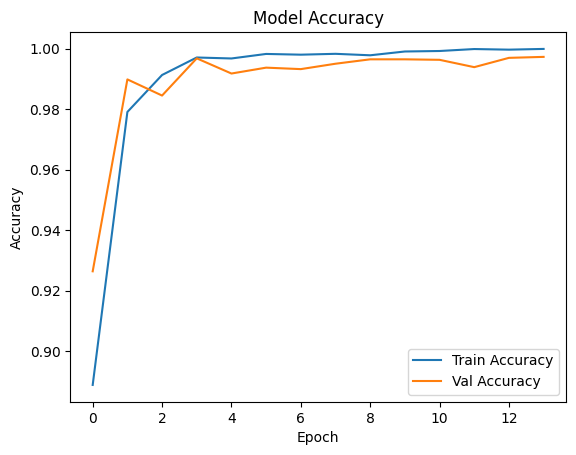

In [36]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

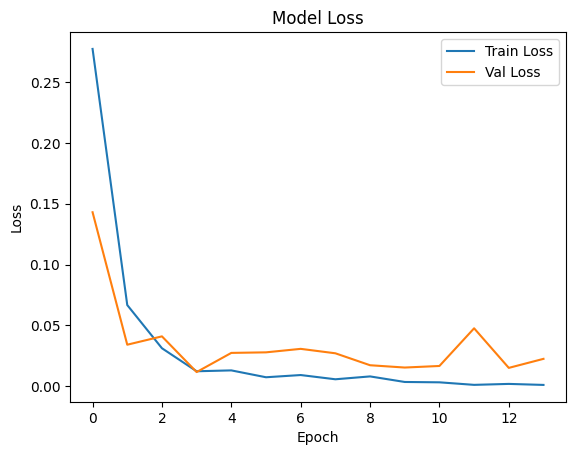

In [37]:
# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

242/242 ━━━━━━━━━━━━━━━━━━━━ 78s 319ms/step


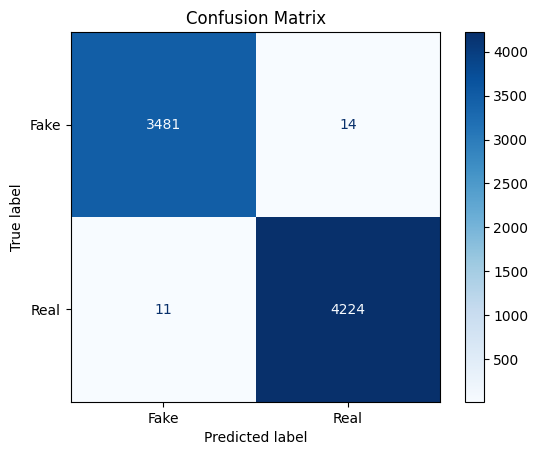

In [38]:
# Predict on test set
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [39]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      3495
        Real       1.00      1.00      1.00      4235

    accuracy                           1.00      7730
   macro avg       1.00      1.00      1.00      7730
weighted avg       1.00      1.00      1.00      7730



In [40]:
sample_text = """
NASA confirms the Earth will permanently lose gravity for 6 seconds on July 10 due to rare planetary alignment,
urging people to stay indoors to avoid floating into the sky.

"""

In [41]:
# Tokenize
sample_seq = tokenizer.texts_to_sequences([sample_text])

# Pad
sample_pad = pad_sequences(sample_seq, maxlen=max_len)

In [42]:
# Predict the probability
prediction = model.predict(sample_pad)

# Get the probability value
prob = prediction[0][0]

# Show result with probability
if prob > 0.5:
    print(f"✅ This article is likely **REAL** news. (Confidence: {prob*100:.2f}%)")
else:
    print(f"❌ This article is likely **FAKE** news. (Confidence: {(1 - prob)*100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
❌ This article is likely **FAKE** news. (Confidence: 100.00%)


In [43]:
model.save("fake_news_detection_final_model.h5")